In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import scipy
import statsmodels.api as s
from sklearn import metrics

import pdb

In [2]:
sub_list = ['AC_newepoch','AM', 'BB','CM','CR','GG','HA','IB','JM','JR','KK','KT','MC','MH','NF','SB','SG','SOG','TL','ZZ']
data_dir = f'/lab_data/behrmannlab/vlad/pepdoc/results_ex1' #read in the file; first value is the file name
curr_dir = f'/user_data/vayzenbe/GitHub_Repos/pepdoc' #CHANGE AS NEEEDED CAUSE ITS FOR VLAAAD
fig_dir = f'{curr_dir}/figures' #where to save the figures
results_dir = f'{curr_dir}/results' #where to save the results

# bin_size = 1 
categories = ['tool','nontool','bird','insect']
labels = np.asanyarray([0]*5 + [1]*5 + [2]*5 + [3]*5) #creates labels for data



pre_stim = 50 #ms before stim onset
stim_end = 300 #ms when stim goes off
post_stim = 500 #ms after stim offset
bin_length = 4 #length of each bin in ms
bin_size = 1 #how many bins were averaged over; 1 = no averaging; 5 = average over 20 ms

#calculate start window for analysis given the bin size and length
start_window = pre_stim - (bin_length*(bin_size-1)) 
#calculate the onset point of the stimulus in the dataframe given the start window and bin length
stim_onset = int(start_window/bin_length)+1 
stim_offset = int(stim_end/bin_length)+stim_onset-1
timepoints = list(range(-start_window, post_stim, bin_length)) #134 20 ms bins


#### Main decoding plots

In [ ]:
"""
Calc bootstrap CIs
"""

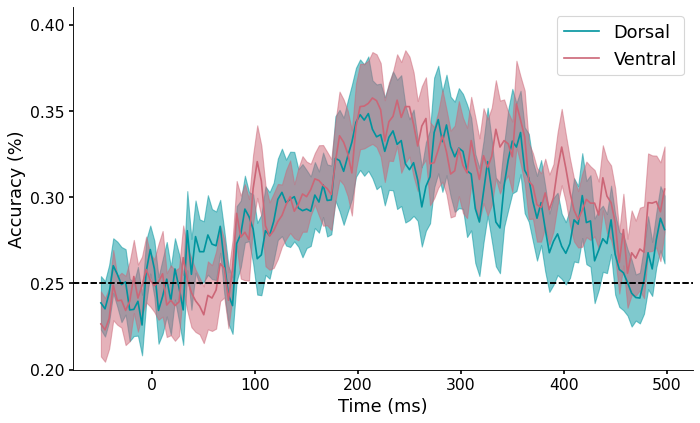

In [21]:
'''
Plot decodeing accuracy for each ROI with shading
'''
rois = ['ventral', 'dorsal']
roi_names = ['Ventral', 'Dorsal']
colors = ['#CC6677','#00949e']

rois = ['dorsal', 'ventral']
colors = ['#00949e','#CC6677']
onsets = [66,82]



plt.figure(figsize=(10, 6), dpi=80)
for roi in enumerate(rois):
    roi_decoding = np.load(f'{results_dir}/decode/{roi[1]}_decoding.npy')
    roi_mean = np.mean(roi_decoding, axis=0)
    
    sem = np.std(roi_decoding, ddof=1, axis =0) / np.sqrt(roi_decoding.shape[0])

    plt.plot(timepoints, roi_mean, label=roi[1].capitalize(), color = colors[roi[0]]) #...plot the data, add error bars to mat plot lib, use standard error of the mean to add., there is a package called psypy to do this (psyplot - SEM)
    plt.axhline(y=0.25, color='k', linestyle='--')
    
    #plt.axhline(y=0.2215, color='k', linestyle='--')
    plt.fill_between(timepoints, roi_mean-sem, roi_mean+sem,alpha=0.5, color = colors[roi[0]])
    plt.legend(fontsize=16)

    plt.xlabel('Time (ms)',fontsize=16)
    plt.ylabel('Accuracy (%)',fontsize=16)
    #plt.axvline(onsets[roi[0]],  linestyle='--', color = colors[roi[0]])
    #plt.yticks(np.arange(min(x), max(x)+1, 1.0))
    plt.xticks(fontsize= 14)
    plt.yticks(fontsize= 14)
    plt.ylim(.2,.41)

    ax = plt.gca()
    ax.xaxis.set_tick_params(width=1.5)
    ax.yaxis.set_tick_params(width=1.5)

    start, end = ax.get_ylim()
    ax.yaxis.set_ticks(np.arange(start, end, .05))

    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    
    #plt.show()
    
    plt.savefig(f'{fig_dir}/decoding_plot.png', dpi=300)


In [67]:
roi_decoding = np.load(f'{results_dir}/decode/dorsal_decoding.npy')
roi_mean = np.mean(roi_decoding, axis=0)
    
np.max(roi_mean)

0.3484375

#### Significance across time

In [40]:
#dorsal
rois = ['dorsal','ventral']
for roi in rois:
    decoding_data = np.load(f'{results_dir}/decode/{roi}_decoding.npy')
    sig_ts = []
    for time in range(0, decoding_data.shape[1]):
        p_val = stats.ttest_1samp((decoding_data[:,time]), .25, axis = 0, alternative='greater')
        sig_ts.append(p_val[1])

    np.save(f'{results_dir}/decode/{roi}_sig_ts.npy', sig_ts)

(0, 'dorsal') 66
(1, 'ventral') 82


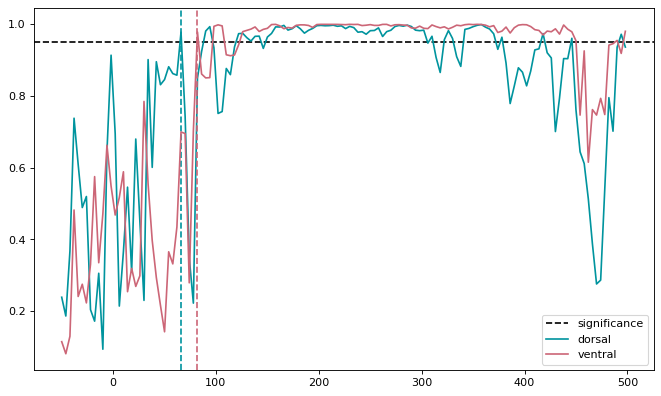

In [41]:
'''
Plot significance time series
'''

rois = ['dorsal','ventral']
line_color = ['#00949e','#CC6677']
alpha_level = .95
plt.figure(figsize=(10, 6), dpi=80)
plt.axhline(alpha_level, color = 'k', label='significance', linestyle='--')
for roi in enumerate(rois):
    sig_data = 1-np.load(f'{results_dir}/decode/{roi[1]}_sig_ts.npy')
    onset = np.min(np.where(sig_data >= alpha_level))
    onset = (onset *bin_length)-start_window
    plt.plot(timepoints, sig_data, label = roi[1], color = line_color[roi[0]])
    plt.axvline(onset,  linestyle='--', color = line_color[roi[0]])
    plt.legend()
    print(roi, onset)





#### Test significant onset

In [48]:
'''
Boot strap participant data and extract onset
'''

rois = ['dorsal','ventral']
iter = 1000

boot_df = pd.DataFrame()
for roi in rois:
    decoding_data = np.load(f'{results_dir}/decode/{roi}_decoding.npy')
    decoding_data = decoding_data[:,stim_onset:]
    decoding_data = pd.DataFrame(decoding_data) #convert to dataframe because it has a good resampling function
    decode_boot = []
    sub_counts = np.zeros((1,decoding_data.shape[1]))

    for ii in range(0,iter):
        
        #resample the sub decode data with replacement
        sub_sample = decoding_data.sample(decoding_data.shape[0],replace = True, random_state=ii)
        
        #convert it back to a numpy array
        sub_sample = sub_sample.to_numpy() 
        
        #calculate the bootstrap sample mean
        sig_boot = []
        
        #only add values if they are significant two timepoints in arow
        sig_consistent = []
        
        sig_ts = []
        for time in range(0,sub_sample.shape[1]):
            p_val= stats.ttest_1samp(sub_sample[:,time], .25, axis = 0, alternative='greater')
            
            #append the p-value for every time point
            sig_ts.append(p_val[1])  


            #mark timepoints that are above chance for at least two timepoints in a row
            if time > 0:

                if sig_ts[time] <= .05 and sig_ts[time-1] <=.05:
                    sig_consistent.append(1)
                else:
                    sig_consistent.append(0)

        #reconvert p-value list into a numpy array
        sig_ts = np.asanyarray(sig_ts)

        #reconvert consistent list into a numpy array
        sig_consistent = np.asanyarray(sig_consistent)
            
        #find the the first time point that is below change (0.05)
        #np.where simply returns the indices (i.e., spots in an array), that meet some condition
        #i'm simply grabbing the first value of that list, which corresponds to the first time point above chance
        try:
            sig_onset = np.where(sig_consistent ==1,)[0][0]
        except:
            sig_onset= decoding_data.shape[1]
        
        
        
        sub_counts[0,np.where(sig_ts <=.05)[0]] += 1
        
        #if d_onset == 1:
        #    pdb.set_trace()
        
        #convert to the actual time point
        sig_onset = (sig_onset *4)

        #add the onset value from the resample to a list
        decode_boot.append(sig_onset)
    
    boot_df[roi] = decode_boot

boot_df.to_csv(f'{results_dir}/onsets/onset_boot_df.csv')

In [63]:
'''
Run binomial test on bootstrapped data
'''

comparisons = [['dorsal','ventral'] ]

for roi in comparisons:
    #Calcualte the time  difference for each bootstrap between roi pairs
    diff = boot_df[roi[0]] - boot_df[roi[1]]

    #count the number of times the first roi precedes the other
    time_count = np.sum(diff < 0)

    print(stats.binom_test(time_count,n=len(diff), p= 0.5, alternative='two-sided'))
    print(time_count)



5.249291116750507e-27
669


/home/vayzenbe/anaconda3/envs/ml_new/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/vayzenbe/anaconda3/envs/ml_new/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


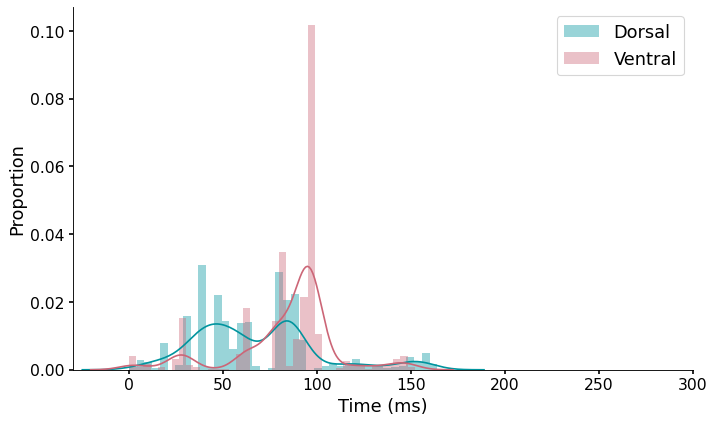

In [22]:
boot_df = pd.read_csv(f'{results_dir}/onsets/onset_boot_df.csv')

colors = ['#00949e','#CC6677']
plt.figure(figsize=(10, 6), dpi=80)
sns.distplot(a=boot_df['dorsal'], label='Dorsal', color=colors[0], bins= 40)
sns.distplot(a=boot_df['ventral'], label='Ventral', color=colors[1], bins= 40)
#plt.hist(boot_df['dorsal'], range = [0, 300], label='Dorsal', color=colors[0], alpha=.5, bins= 74, density=True)
#plt.hist(boot_df['ventral'],range = [0, 300], label='Ventral', color=colors[1], alpha=.5, bins= 74, density=True)
#plt.hist(c_boot,range = [0, 150], label='control', color='g', alpha=.5, bins= 150, density=True)


plt.ylabel('Proportion')
plt.legend(loc='upper right')

plt.legend(fontsize=16)

plt.xlabel('Time (ms)',fontsize=16)
plt.ylabel('Proportion',fontsize=16)
#plt.axvline(onsets[roi[0]],  linestyle='--', color = colors[roi[0]])
#plt.yticks(np.arange(min(x), max(x)+1, 1.0))
plt.xticks(fontsize= 14)
plt.yticks(fontsize= 14)


ax = plt.gca()
ax.xaxis.set_tick_params(width=1.5)
ax.yaxis.set_tick_params(width=1.5)

#start, end = ax.get_ylim()
#ax.yaxis.set_ticks(np.arange(start, end, .05))

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

ax.set_xlim(-30,300)

plt.savefig(f'{fig_dir}/onset_histogram.png', dpi=300)

In [65]:
np.mean(diff)

-15.952

In [61]:
#plot the difference values with confidence intervals
alpha = .05
ci_low = np.percentile(diff, alpha*100)
ci_high= np.percentile(diff, 100-alpha*100)
print(ci_low,ci_high)

-68.0 56.0


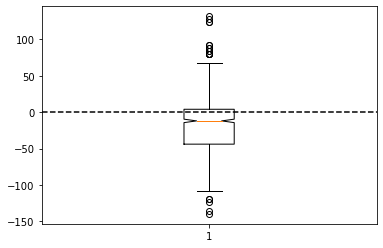

In [60]:
plt.boxplot(diff,notch=True)
plt.axhline(0, color = 'k', label='significant', linestyle='--')

#### Granger causality

In [23]:
gca = pd.read_csv(f'{results_dir}/mvgca/mvgca_summary.csv')

<AxesSubplot:ylabel='dorsal_ventral'>

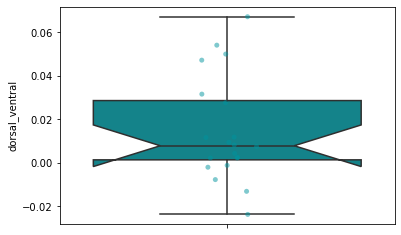

In [25]:
sns.boxplot(y=gca['dorsal_ventral'], color = '#00949e', notch=True)
 
# make grouped stripplot
sns.stripplot(y=gca['dorsal_ventral'], color = '#00949e',
              marker='o', 
              alpha=0.5)

#### Time generalized RSA analyses

In [67]:
corr_ts = np.load(f'{results_dir}/rsa/dorsal_ventral_corr_ts.npy')
corr_ts = corr_ts[stim_onset:stim_offset,stim_onset:stim_offset]


In [96]:
corr_df = pd.DataFrame()
corr_df['corrs'] = corr_ts.flatten()
inds = np.triu_indices(n=corr_ts.shape[0],k=1)
right_side = corr_ts[inds] #extract lower triangle
left_side = corr_ts[(inds[1],inds[0])] #extract upper triangle

In [97]:
x_coord = []
y_coord = []
offset = []
label = []

inds = np.triu_indices(n=corr_ts.shape[0],k=1)
right_side = corr_ts[inds] #extract lower triangle
left_side = corr_ts[(inds[1],inds[0])] #extract upper triangle

for corr in corr_df['corrs']:
    if len(np.where(right_side == corr)[0]) == 1:
        label.append('Dorsal')
    if len(np.where(left_side == corr)[0]) == 1:
        label.append('Ventral')
    elif len(np.where(right_side == corr)[0]) == 0 and len(np.where(left_side == corr)[0]) == 0:
        label.append('Same')
    

    curr_x = np.where(corr_ts == corr)[0]
    curr_y = np.where(corr_ts == corr)[1]
    x_coord.append(curr_x)
    y_coord.append(curr_y)

    offset.append((curr_x- curr_y)*4)

corr_df['x_coord'] = x_coord
corr_df['y_coord'] = y_coord
corr_df['offset'] = offset
corr_df['label'] = label



In [ ]:
corr_df.to_csv(f'{results_dir}/rsa/dorsal_ventral_corrs.csv')

In [98]:
corr_df = corr_df.sort_values(by='corrs', ascending=False)
corr_df = corr_df.reset_index()

In [109]:
test = corr_df.iloc[0:100,:]

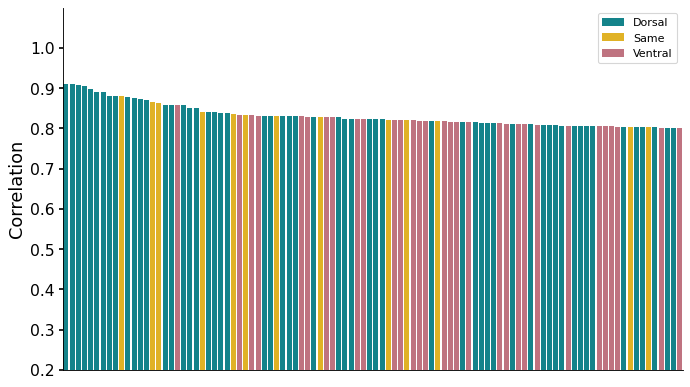

In [119]:
plt.figure(figsize=(10, 6), dpi=80)
sns.barplot(y=test['corrs'], x = test.index,order = test.index, hue = test['label'],dodge = False,
            palette = ['#00949e','#FFC107','#CC6677'])
ax = plt.gca()
ax.set(xticklabels=[])
ax.tick_params(bottom=False)  # remove the ticks
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.ylabel('Correlation',fontsize=16)
#plt.axvline(onsets[roi[0]],  linestyle='--', color = colors[roi[0]])
#plt.yticks(np.arange(min(x), max(x)+1, 1.0))
plt.xticks(fontsize= 14)
plt.yticks(fontsize= 14)
plt.ylim(.2,1.1)

ax = plt.gca()
ax.xaxis.set_tick_params(width=1.5)
ax.yaxis.set_tick_params(width=1.5)

start, end = ax.get_ylim()
ax.yaxis.set_ticks(np.arange(start, end, .1))


ax.legend_.set_title(None)

#plt.show()

plt.savefig(f'{fig_dir}/correlation_hist.png', dpi=300)


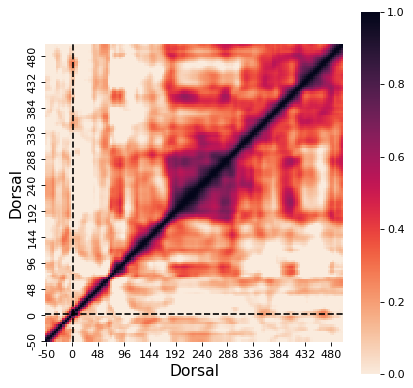

<Figure size 432x288 with 0 Axes>

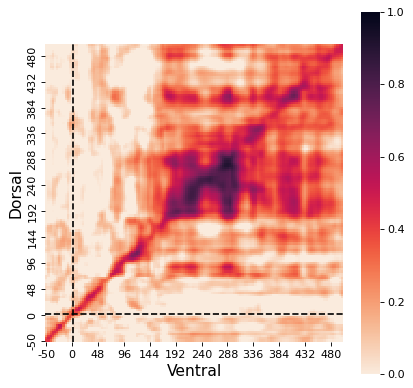

<Figure size 432x288 with 0 Axes>

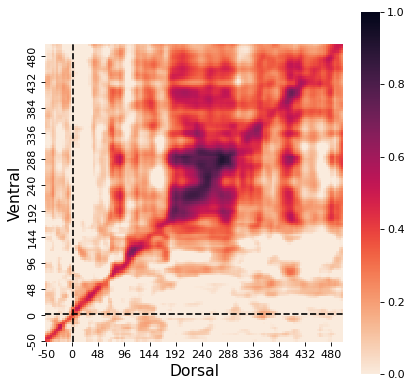

<Figure size 432x288 with 0 Axes>

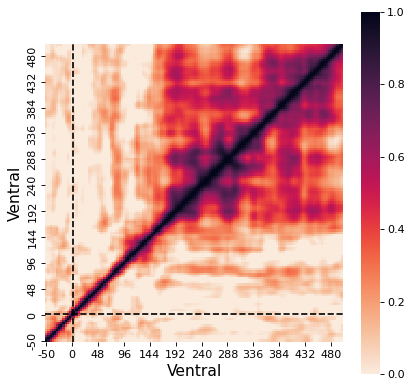

<Figure size 432x288 with 0 Axes>

In [130]:
"""
Plot time generalization RDMs
"""

rois = ['dorsal','ventral']
#rois = ['dorsal']

#timepoints = np.asanyarray(timepoints)
time_cols = np.asanyarray(timepoints)
time_cols[1:] = time_cols[1:] + 2
for roi1 in rois:
    for roi2 in rois:
        plt.figure(figsize=(6, 6), dpi=80)
        corr_ts = np.load(f'{results_dir}/rsa/{roi1}_{roi2}_corr_ts.npy')
        
        corr_df = pd.DataFrame(corr_ts, columns = time_cols, index = time_cols)
        #corr_df = corr_df.iloc[stim_onset:stim_offset,stim_onset:stim_offset]
        ax = sns.heatmap(corr_df,xticklabels=12,yticklabels=12, vmin = 0, vmax = 1, square = True,
            cmap= "rocket_r")
        #ax.set_title(f'{roi1} {roi2}')
        ax.invert_yaxis()
        plt.axvline(13,  linestyle='--', color = 'black')
        plt.axhline(13,  linestyle='--', color = 'black')
        plt.ylabel(roi1.capitalize(), fontsize=14)
        plt.xlabel(roi2.capitalize(), fontsize=14)
        #cbar = ax.collections[0].colorbar
        #cbar.ax.tick_params(labelsize=12)
        #cbar.ax.clabel


        #ax.set(xticklabels=[])
        #ax.tick_params(bottom=False)  # remove the ticks
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        plt.show()
        plt.savefig(f'{fig_dir}/{roi1}_{roi2}_time_generalization.png', dpi=300)
    

In [47]:
"""
Test whether RDMs are right shifted or left shifted
"""
rois = ['dorsal','ventral','control']


#timepoints = np.asanyarray(timepoints)
time_cols = np.asanyarray(timepoints)
time_cols[1:] = time_cols[1:] + 2
df = pd.DataFrame()
for roi1 in rois:
    for roi2 in rois:
        if roi1 == roi2:
            continue
        else:
            corr_ts = np.load(f'{results_dir}/rsa/{roi1}_{roi2}_corr_ts.npy')
            corr_ts = corr_ts[stim_onset:stim_offset,stim_onset:stim_offset]

            #extract left and right sides of the diagnol
            inds = np.triu_indices(n=corr_ts.shape[0],k=1)
            right_side = corr_ts[inds] #extract lower triangle
            left_side = corr_ts[(inds[1],inds[0])] #extract upper triangle

            #calculate the difference between the left and right sides
            #if positive, then right shifted
            diff = right_side - left_side


            df[f'{roi1}_{roi2}'] = diff
            #left side rdm




In [45]:
(74*73)/2

2701.0

Text(0, 0.5, 'Time Diff')

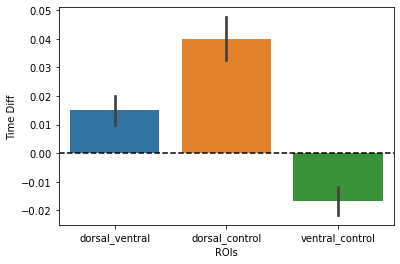

In [48]:
sns.barplot(data = df[['dorsal_ventral','dorsal_control','ventral_control']],n_boot=10000,)
plt.axhline(0, color = 'k', label='significant', linestyle='--')
plt.xlabel('ROIs')
plt.ylabel('Time Diff')

In [38]:
"""
Test whether RDMs are right shifted or left shifted
"""
rois = ['dorsal','ventral','control']

time_offset = 13
#timepoints = np.asanyarray(timepoints)
time_cols = np.asanyarray(timepoints)
time_cols[1:] = time_cols[1:] + 2
df = pd.DataFrame()
for roi1 in rois:
    for roi2 in rois:
        if roi1 == roi2:
            continue
        else:
            corr_ts = np.load(f'{results_dir}/rsa/{roi1}_{roi2}_corr_ts.npy')
            corr_ts = corr_ts[stim_onset:stim_offset,stim_onset:stim_offset]

            eye_mat = np.eye(corr_ts.shape[0],corr_ts.shape[1], k = 0)
            for t in range(1,time_offset):
                eye_mat = eye_mat+ np.eye(corr_ts.shape[0],corr_ts.shape[1], k = t)
                eye_mat = eye_mat+ np.eye(corr_ts.shape[0],corr_ts.shape[1], k = -t)

            corr_ts =corr_ts*eye_mat

            #extract left and right sides of the diagnol
            inds = np.triu_indices(n=corr_ts.shape[0],k=1)
            diaganol = corr_ts[np.triu_indices(n=corr_ts.shape[0],k=0)] #extract lower triangle
            right_side = corr_ts[inds] #extract lower triangle
            left_side = corr_ts[(inds[1],inds[0])] #extract upper triangle

            #remove zeros
            diaganol = diaganol[diaganol != 0]
            left_side = left_side[left_side != 0]
            right_side = right_side[right_side != 0]

            #calculate the difference between the left and right sides
            #if positive, then right shifted
            diff = right_side - left_side


            df[f'{roi1}_{roi2}'] = diff
    
            #left side rdm




In [34]:
(np.sum(eye_mat == 1) -74)/2

621.0

In [39]:
df.mean()

dorsal_ventral     0.013766
dorsal_control     0.013087
ventral_dorsal    -0.013766
ventral_control   -0.047894
control_dorsal    -0.013087
control_ventral    0.047894
dtype: float64

Text(0, 0.5, 'Time Diff')

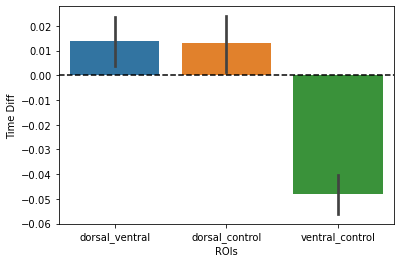

In [40]:
sns.barplot(data = df[['dorsal_ventral','dorsal_control','ventral_control']])
plt.axhline(0, color = 'k', label='significant', linestyle='--')
plt.xlabel('ROIs')
plt.ylabel('Time Diff')

In [42]:
(74*73)/2

2701.0

In [36]:
df.mean()

dorsal_ventral    -0.013959
dorsal_control    -0.037893
ventral_dorsal     0.013959
ventral_control    0.015562
control_dorsal     0.037893
control_ventral   -0.015562
dtype: float64

In [72]:
(74*73)/2

2701.0